## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [ ]:
## 使用Colab可先run這裡的code
#假如要連結自己的雲端硬碟再開啟
from google.colab import drive
drive.mount('/content/gdrive')
# 檢查GPU
!nvidia-smi
# #安裝產生驗證碼的套件

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!pip install google-colab

  Created wheel for google-colab: filename=google_colab-1.0.0-py2.py3-none-any.whl size=102298 sha256=c2afc7819b56fbcf32f1a4671571ae0d831f7cb02f79e157153eafb78fe96785
  Stored in directory: c:\users\ljy\appdata\local\pip\cache\wheels\f6\3b\58\f34ea9045a7c69bd5634978bf25ac60277e90997d9e6e74192
  Created wheel for portpicker: filename=portpicker-1.2.0-py3-none-any.whl size=13370 sha256=9b0cfe16a94dea5e0e157b0e133f2a0806ecd0988a0a85827f5f046e1a190cf5
  Stored in directory: c:\users\ljy\appdata\local\pip\cache\wheels\73\0c\f5\35977446e45e818e6b848be3d41e7f38298a5102f4dcda21c6
  Created wheel for tornado: filename=tornado-4.5.3-cp37-cp37m-win_amd64.whl size=425599 sha256=6dd595b51276861667eb5211558d15db96b83148d002e97d220442ae6e20d736
  Stored in directory: c:\users\ljy\appdata\local\pip\cache\wheels\a2\45\43\36ec7a893e16c1212a6b1505ded0a2d73cf8e863a0227c8e04
Successfully built google-colab portpicker tornado
  Attempting uninstall: six
    Found existing installation: six 1.14.0
    Uninst

ERROR: tensorflow 1.14.0 requires google-pasta>=0.1.6, which is not installed.
ERROR: pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
ERROR: pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
ERROR: astroid 2.3.3 requires typed-ast<1.5,>=1.4.0; implementation_name == "cpython" and python_version < "3.8", which is not installed.
ERROR: spyder-kernels 1.8.1 has requirement ipykernel>=5.1.3; python_version > "2", but you'll have ipykernel 4.6.1 which is incompatible.
ERROR: jupyter-console 6.1.0 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.18 which is incompatible.
ERROR: distributed 2.11.0 has requirement tornado>=5; python_version < "3.8", but you'll have tornado 4.5.3 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 存取被拒。: 'c:\\users\\ljy\\anaconda3\\lib\\site-packages\\~ornado\\speedups.cp37-win_amd64.pyd'
Consider using the `--u

## 記得先 pip install captcha

In [1]:
!pip install captcha

     |████████████████████████████████| 102kB 4.1MB/s 


## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'TIFC')

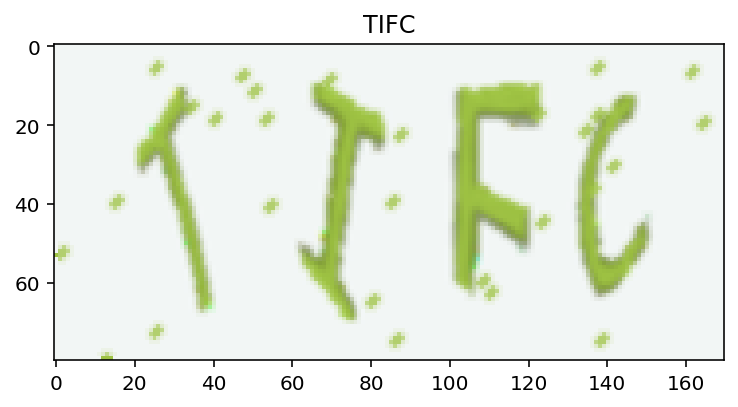

In [2]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [3]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [14]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor

for i in range(4):
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)

##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)


##包裝用來預測的model
base_model = Model(inputs=[input_tensor], outputs=[x])


##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

In [15]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 80, 170, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 78, 168, 32)  896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 78, 168, 32)  128         conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_48[0][0]     
_______________________________________________________________________________________

In [11]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[17 27 32 31]]
CNN輸出寬度:  [13.]
字串長度(可浮動):  [4.]


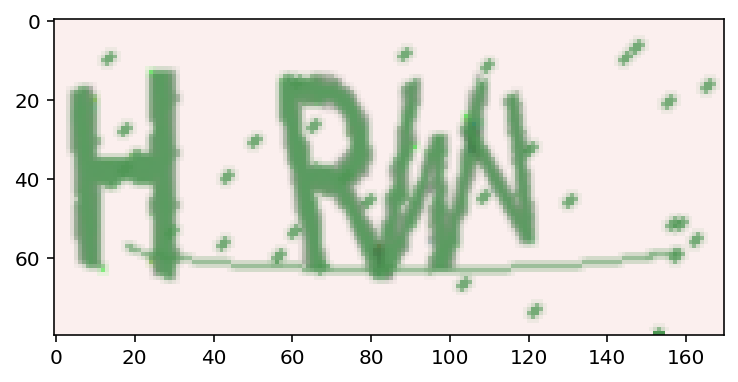

In [16]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [17]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=30)

Epoch 1/30
300/300 [==============================] - 53s 175ms/step - loss: 15.3193
Epoch 2/30
300/300 [==============================] - 52s 174ms/step - loss: 11.1893
Epoch 3/30
300/300 [==============================] - 53s 176ms/step - loss: 7.9403
Epoch 4/30
300/300 [==============================] - 53s 176ms/step - loss: 6.2363
Epoch 5/30
300/300 [==============================] - 53s 175ms/step - loss: 5.2222
Epoch 6/30
300/300 [==============================] - 53s 176ms/step - loss: 4.5116
Epoch 7/30
300/300 [==============================] - 53s 177ms/step - loss: 4.0957
Epoch 8/30
300/300 [==============================] - 53s 177ms/step - loss: 3.7332
Epoch 9/30
300/300 [==============================] - 53s 177ms/step - loss: 3.5303
Epoch 10/30
300/300 [==============================] - 53s 177ms/step - loss: 3.3493
Epoch 11/30
300/300 [==============================] - 53s 176ms/step - loss: 3.1567
Epoch 12/30
300/300 [==============================] - 53s 178ms/step - 

## 預測

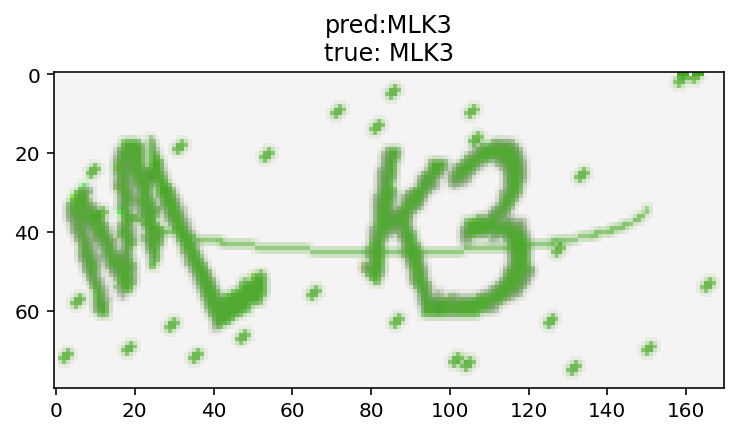

In [30]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
# print(y_pred)

##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])[:4]
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

## 自己寫 decode CTC

In [ ]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

## 額外參考：加入RNN的神經網路

In [ ]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Convolution2D(32, 3, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru1_b')(x)
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru1_merged)
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  # Remove the CWD from sys.path while we load stuff.
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/Users/chening/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU

In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 78, 168, 32)  896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 78, 168, 32)  128         conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_25[0][0]     
__________________________________________________________________________________________________
batch_norm